In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [9]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
border = simage.get_border(join(dir_git,'surfAnalysisPy'))

In [12]:
hem = 'L'

In [13]:
list_sn = su.get_list_sn()

---

In [14]:
glm = 2
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_2'

---

### Define MVPA function

In [53]:
# Define the MVPA function that will be used in the searchlight
# The functions take a n_images x n_voxels array as input.
# and return either a scalar or vector as output.
# Here we use simple example that calculate the mean activity in the searchlight region.
def func_mvpa_Dist(data, **kwargs):
    obs_des = {
        'cond_vec': kwargs['cond_vec'],
        'part_vec': kwargs['part_vec']
    }
    # set the dataset
    Y = pcm.dataset.Dataset(
        measurements=data,
        obs_descriptors=obs_des
    )
    # the second moment matrix G
    G_hat, _ = pcm.est_G_crossval(
        Y=Y.measurements,
        Z=Y.obs_descriptors['cond_vec'],
        part_vec=Y.obs_descriptors['part_vec'],
        X=pcm.matrix.indicator(Y.obs_descriptors['part_vec'])
    )
    dist = pcm.G_to_dist(G_hat)

    mean_dist = np.triu(dist, k=1).mean()

    return mean_dist

---

### Run MVPA

In [54]:
dir_output = join(dir_glm, 'surfaceWB')
exists(dir_output)

True

In [55]:
orders = np.array(['B_L','B_S','S_L','S_S','C_L','C_S','N_L','N_S','Rest'])

In [56]:
maxlen = max(len(s) for s in orders)
orders = np.array([s.ljust(maxlen) for s in orders])
orders

array(['B_L ', 'B_S ', 'S_L ', 'S_S ', 'C_L ', 'C_S ', 'N_L ', 'N_S ',
       'Rest'], dtype='<U4')

In [58]:
for sn in tqdm(list_sn):
    subj = 'S'+sn

    ## We can now use the pre-computed searchlight.
    fname = join(su.get_dir_surf(),subj,'%s.searchlight_surface.h5'%subj)
    mySearchlight = sl.load(fname)
    # print(f'Average size of the searchlight: {mySearchlight.radius.mean():.1f} mm')
    # print(f'Average number of voxels: {mySearchlight.nvoxels.mean():.1f}')
    
    dir_work = join(dir_glm,'surfaceWB',subj)

    ## load reginfo.tsv
    reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
    part_vec = reginfo.run.values
    cond_vec = np.array(
        [int(np.where(orders==cond)[0][0])+1 for cond in reginfo.name.values]
    )
    obs_des = {'part_vec': part_vec, 'cond_vec': cond_vec}

    ## set betas
    dataset = [join(dir_glm,subj,'beta_%04d.nii'%(ii+1)) for ii in range(len(cond_vec))]
    
    ## Run the searchlight with the defined scalar MVPA function
    results = mySearchlight.run(dataset, func_mvpa_Dist, obs_des, verbose=False)

    ## save the result
    mySearchlight.data_to_cifti(results, outfilename=join(dir_output,subj,'%s.glm_%d.mvpa.mean_dist.dscalar.nii'%(subj,glm)))

100%|████████████████████████████████████████████████| 12/12 [1:56:58<00:00, 584.85s/it]


---

### Plot the result

In [59]:
dataset = np.ones((len(list_sn),32492)) * np.nan
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## load the setup file
    fname = join(su.get_dir_surf(),subj,'%s.searchlight_surface.h5'%subj)
    mySearchlight = sl.load(fname)

    ## check the indeces of centers
    idx = mySearchlight.center_indx

    ## load the result
    fname = join(dir_glm,'surfaceWB',subj,'%s.glm_%d.mvpa.mean_dist.dscalar.nii'%(subj,glm))
    # fname = join(dir_glm,'surfaceWB',subj,'%s.glm_%d.searchlight_surface.dscalar.nii'%(subj,glm))
    cifti = nb.load(fname)
    
    dataset[ii,idx] = cifti.get_fdata()
    
    del cifti, mySearchlight

100%|███████████████████████████████████████████████████| 12/12 [04:17<00:00, 21.48s/it]


In [60]:
res = scipy.stats.ttest_1samp(dataset, popmean=0, axis=0)
thresh = su.convert_alpha_to_tval(alpha=0.05, df=np.nanmean(res.df).astype(int))
idx = res.statistic > thresh

/tmp/ipykernel_146726/2795848002.py:1: RuntimeWarning: Mean of empty slice
  data = np.nanmean(dataset, axis=0)


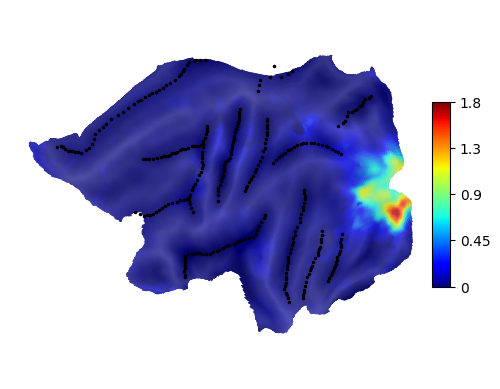

In [61]:
data = np.nanmean(dataset, axis=0)
g = surf.plot.plotmap(
    data=data * idx,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet, colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib',
)
# g.text(x=40, y=250, s=sss, ha='center', va='center', fontsize=20)

---